## Prepare stochastic programming modeling procedure
### Step 1
<ol>
<li>Read mean and variance for each hour of the day (e.g. summer).</li>
<li>Read aggregated nominal output power for each aggregator.</li>
<li>Select confidence factor.</li>
<li>From distribution select certain irradiance/speed and calculate the value which satisfies the confidence factor.</li>
<li>Calulate output power of the aggregated solar/wind installation.</li>
<li>Solve the bi-level model and obtain optimal values for controlled variables.</li>

### Step 2 - Monte Carlo
<li>Fix optimal control variables.</li>
<li>Relax network constraints (voltage and current).</li>
<li>Solve the problem many times by drawing random variables from given distribution.</li>
<li>Analyze the robustness of the solution by looking at how many times were network constraints violated.</li>
</ol>

In [246]:
from scipy.stats import norm, beta, weibull_min, multivariate_normal
from scipy.special import gamma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import choices
from matplotlib import cm

plt.style.use({'figure.facecolor':'white'})

### Step 1 - without optimization

In [247]:
filename = 'Input_Files/InputData34.xlsx'
PVData = pd.read_excel(filename, sheet_name='PVData')
PVGeneration = pd.read_excel(filename, sheet_name='PVGeneration')
WindData = pd.read_excel(filename, sheet_name='WindData')
WindGeneration = pd.read_excel(filename, sheet_name='WindGeneration')
SystemDemand = pd.read_excel(filename, sheet_name='SystemDemand')
AggData = pd.read_excel(filename, sheet_name='AggData')

In [248]:
mu_st = {t:PVGeneration.loc[t, 'mean'] for t in PVGeneration.index}
var_st = {t:PVGeneration.loc[t, 'variance'] for t in PVGeneration.index}
mu_wt = {t:WindGeneration.loc[t, 'mean'] for t in WindGeneration.index}
var_wt = {t:WindGeneration.loc[t, 'variance'] for t in WindGeneration.index}
eta_conf = 10/100       #% confidence interval

wsin = 3                #Cut-in wind speed in (m/s)
wsr = 12                #Rated wind speed in (m/s)
wsout = 20              #Cut-off wind speed in (m/s)
Pwpp = 150              #Max. kW of aggregated wind
Ppv = 200               #Max. kW of aggregated solar

def renewable_sources(case, eta_conf):
    irrad = []; Ppvt = []
    wind = []; Pwt = []

    if case == 'Monte Carlo':
        for t in PVGeneration.index:
            if mu_st[t] == 0:
                irrad.append(0)
            else:
                b = (1 - mu_st[t])*(mu_st[t]*(1 + mu_st[t])/var_st[t] - 1)
                a = mu_st[t]*b/(1 - mu_st[t])
                irrad_spectrum = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
                irrad.append(choices(irrad_spectrum, beta.pdf(irrad_spectrum, a, b))[0])
            Ppvt.append(irrad[t]*Ppv)

        for t in WindGeneration.index:
            kappa = (np.sqrt(var_wt[t])/mu_wt[t])**(-1.086)
            lambd = mu_wt[t]/gamma(1 + 1/kappa)
            wind_spectrum = np.linspace(weibull_min.ppf(0.01, kappa, scale=lambd), weibull_min.ppf(0.99, kappa, scale=lambd), 100)
            wind.append(choices(wind_spectrum, weibull_min.pdf(wind_spectrum, kappa, scale=lambd))[0])
            #calculate output power of wind turbine as a function of wind speed
            if wind[t] < wsin:
                Pwt.append(0)
            elif wsin < wind[t] < wsr:
                Pwt.append(Pwpp*(wind[t]**3 - wsin**3)/(wsr**3 - wsin**3))
            elif wsr < wind[t] < wsout:
                Pwt.append(Pwpp)
            elif wind[t] > wsout:
                Pwt.append(0)
        return irrad, wind, Ppvt, Pwt

    elif case == 'Bilevel':
        for t in PVGeneration.index:
            if mu_st[t] == 0:
                irrad.append(0)
            else:
                b = (1 - mu_st[t])*(mu_st[t]*(1 + mu_st[t])/var_st[t] - 1)
                a = mu_st[t]*b/(1 - mu_st[t])
                irrad.append(beta.ppf(1 - eta_conf, a, b))
            Ppvt.append(irrad[t]*Ppv)

        for t in WindGeneration.index:
            kappa = (np.sqrt(var_wt[t])/mu_wt[t])**(-1.086)
            lambd = mu_wt[t]/gamma(1 + 1/kappa)
            wind.append(weibull_min.ppf(1 - eta_conf, kappa, scale=lambd))
            #calculate output power of wind turbine as a function of wind speed
            if wind[t] < wsin:
                Pwt.append(0)
            elif wsin < wind[t] < wsr:
                Pwt.append(Pwpp*(wind[t]**3 - wsin**3)/(wsr**3 - wsin**3))
            elif wsr < wind[t] < wsout:
                Pwt.append(Pwpp)
            elif wind[t] > wsout:
                Pwt.append(0)
        return irrad, wind, Ppvt, Pwt

    else:
        print('Invalid input!')

In [249]:
def load(case):
    Pd_stoch = []; Qd_stoch = []
    Pd = {t:SystemDemand.loc[t, 'PD']*130.3 for t in SystemDemand.index}
    Qd = {t:SystemDemand.loc[t, 'PD']*30 for t in SystemDemand.index}

    if case == 'Monte Carlo':
        for t in SystemDemand.index:
            mean = [Pd[t], Qd[t]]
            cov = [[Pd[t]/5, 0.6], [0.6, Qd[t]/5]]
            rv = multivariate_normal(mean=mean, cov=cov)
            P, Q = rv.rvs()
            Pd_stoch.append(P)
            Qd_stoch.append(Q)
        return Pd_stoch, Qd_stoch
    elif case == 'Bilevel':
        return Pd, Qd

### Step 2 - without optimization

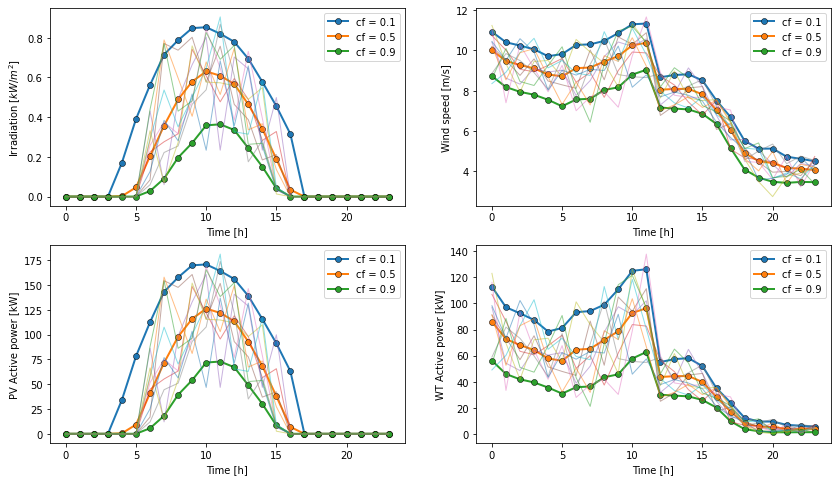

In [250]:
eta_conf = [0.1, 0.5, 0.9]

fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(14,8))
for i in eta_conf:
    irrad, wind, Ppvt, Pwt = renewable_sources('Bilevel', i)

    ax[0,0].plot(PVGeneration.index, irrad, '-o', lw=2, alpha=1, label='cf = '+str(i), markeredgecolor='k', markeredgewidth=0.5);ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Irradiation [$kW/m^2$]');ax[0,0].legend()
    ax[0,1].plot(WindGeneration.index, wind, '-o', lw=2, alpha=1, label='cf = '+str(i), markeredgecolor='k', markeredgewidth=0.5);ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Wind speed [m/s]');ax[0,1].legend()

    ax[1,0].plot(PVGeneration.index, Ppvt, '-o', lw=2, alpha=1, label='cf = '+str(i), markeredgecolor='k', markeredgewidth=0.5);ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('Active power [kW]');ax[1,0].legend()
    ax[1,1].plot(WindGeneration.index, Pwt, '-o', lw=2, alpha=1, label='cf = '+str(i), markeredgecolor='k', markeredgewidth=0.5);ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('Active power [kW]');ax[1,1].legend();

for i in range(10):
    irrad, wind, Ppvt, Pwt = renewable_sources('Monte Carlo', eta_conf)

    ax[0,0].plot(PVGeneration.index, irrad, lw=1, alpha=0.5);ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Irradiation [$kW/m^2$]');ax[0,0].legend()
    ax[0,1].plot(WindGeneration.index, wind, lw=1, alpha=0.5);ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Wind speed [m/s]');ax[0,1].legend()

    ax[1,0].plot(PVGeneration.index, Ppvt, lw=1, alpha=0.5);ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('PV Active power [kW]');ax[1,0].legend()
    ax[1,1].plot(WindGeneration.index, Pwt, lw=1, alpha=0.5);ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('WT Active power [kW]');ax[1,1].legend();

plt.savefig('Visualization/daily_gen.png', bbox_inches='tight')

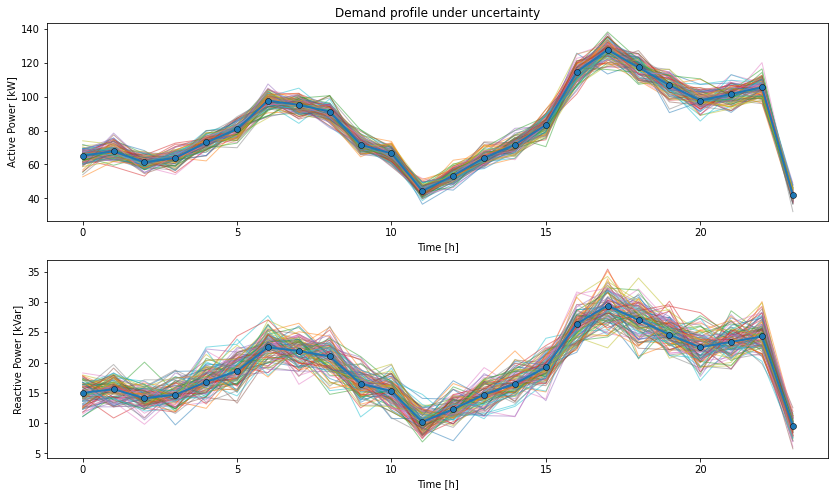

In [251]:
figL, axL = plt.subplots(nrows=2, ncols=1, squeeze=False, figsize=(14,8))

for i in range(100):
    Pd, Qd = load('Monte Carlo')
    axL[0,0].plot(SystemDemand.index, Pd, lw=1, alpha=0.5);axL[0,0].set_xlabel('Time [h]');axL[0,0].set_ylabel('Irradiation [$kW/m^2$]')
    axL[1,0].plot(SystemDemand.index, Qd, lw=1, alpha=0.5);axL[1,0].set_xlabel('Time [h]');axL[1,0].set_ylabel('Wind speed [m/s]')

Pd, Qd = load('Bilevel')
axL[0,0].plot(SystemDemand.index, list(Pd.values()), '-o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5);axL[0,0].set_xlabel('Time [h]');axL[0,0].set_ylabel('Active Power [kW]')
axL[1,0].plot(SystemDemand.index, list(Qd.values()), '-o', lw=2, alpha=1, markeredgecolor='k', markeredgewidth=0.5);axL[1,0].set_xlabel('Time [h]');axL[1,0].set_ylabel('Reactive Power [kVar]')
axL[0,0].set_title('Demand profile under uncertainty');

### Test first approach - stochastic load

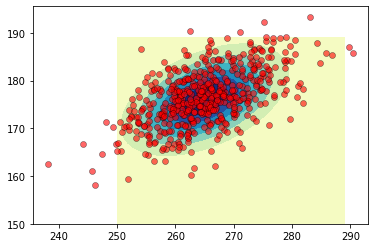

In [252]:
# define mean, variance and demand correlation for single node at time t
Pmu = 265;Qmu = 176;ro = 20

mean = [Pmu, Qmu]
# construct covariance matrix ([[var, corr],[var, corr]])
cov = [[Pmu/5, ro], [ro, Qmu/5]]

# initialize multivariate normal random variable with mean and covariance matrix
rv = multivariate_normal(mean=mean, cov=cov)
# create a grid to visualize the random variable sample space
x, y = np.mgrid[250:290:1, 150:190:1]
pos = np.dstack((x, y))

fig = plt.figure()
ax = fig.add_subplot(111)
# plot 2D contour of the probability density function of random variable
ax.contourf(x, y, rv.pdf(pos), cmap=cm.YlGnBu)

for i in range(500):
    # rvs() method allows to draw random samples from a multivariate normal distribution.
    x1, y1 = rv.rvs()
    ax.plot(x1, y1, 'ro', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)

# Pmu = 2650;Qmu = 1760;ro = 0.6
# mean = [Pmu, Qmu]
# cov = [[Pmu/5, ro], [ro, Qmu/5]]
# rv = multivariate_normal(mean=mean, cov=cov)
# for i in range(50):
#     # rvs() method allows to draw random samples from a multivariate normal distribution.
#     x1, y1 = rv.rvs()
#     ax.plot(x1/10, y1/10, 'go', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)
#
# Pmu = 26500;Qmu = 17600;ro = 0.6
# mean = [Pmu, Qmu]
# cov = [[Pmu/5, ro], [ro, Qmu/5]]
# rv = multivariate_normal(mean=mean, cov=cov)
# for i in range(50):
#     # rvs() method allows to draw random samples from a multivariate normal distribution.
#     x1, y1 = rv.rvs()
#     ax.plot(x1/100, y1/100, 'bo', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)

# Pmu = 265;Qmu = 176;ro = 30
# mean = [Pmu, Qmu]
# cov = [[Pmu/5, ro], [ro, Qmu/5]]
# rv = multivariate_normal(mean=mean, cov=cov)
# for i in range(50):
#     # rvs() method allows to draw random samples from a multivariate normal distribution.
#     x1, y1 = rv.rvs()
#     ax.plot(x1, y1, 'go', alpha=.6, markeredgecolor='k', markeredgewidth=0.5)

### Test second approach - stochastic load

In [253]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) *
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 300 # grid size
    x1s = np.linspace(-20, 20, num=nb_of_x)
    x2s = np.linspace(-20, 20, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]),
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

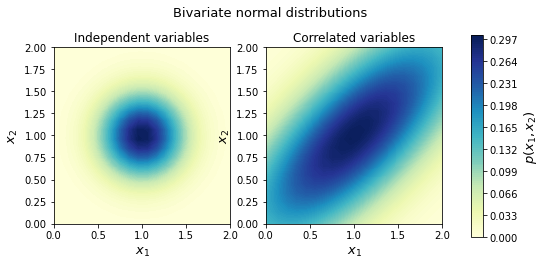

In [257]:
#EXAMPLE (https://peterroelants.github.io/posts/multivariate-normal-primer/)

# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]),
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[1.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [.1, 0.],
    [0., .1]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([0, 2, 0, 2])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[1.], [1.]])  # Mean
bivariate_covariance = np.matrix([
    [.8, 0.6],
    [0.6, .8]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([0, 2, 0, 2])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()

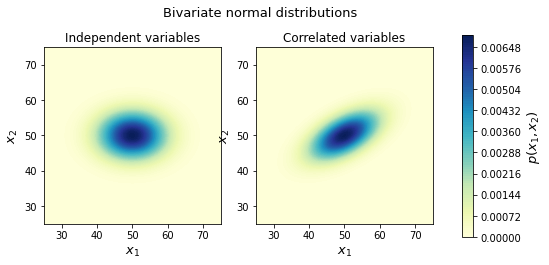

In [278]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(25, 75, num=nb_of_x)
    x2s = np.linspace(25, 75, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]),
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[50.], [50.]])  # Mean
bivariate_covariance = np.matrix([
    [40., 0*20],
    [0*20, 20.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([25, 75, 25, 75])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[50.], [50.]])  # Mean
bivariate_covariance = np.matrix([
    [40., 0.8*20],
    [0.8*20, 20.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([25, 75, 25, 75])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()

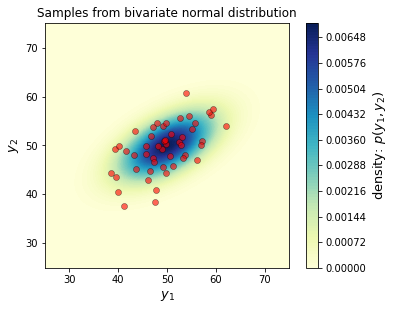

In [279]:
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(25, 75, num=nb_of_x)
    x2s = np.linspace(25, 75, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]),
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

mean = np.matrix([[50.], [50.]])  # Mean
covariance = np.matrix([
    [40., 0.8*20],
    [0.8*20, 20.]])  # Covariance

# Create L
L = np.linalg.cholesky(covariance)
# Sample X from standard normal
n = 50  # Samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

# Plot the samples and the distribution
fig, ax = plt.subplots(figsize=(6, 4.5))
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
# Plot samples
ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$y_1$', fontsize=13)
ax.set_ylabel('$y_2$', fontsize=13)
ax.axis([25, 75, 25, 75])
ax.set_aspect('equal')
ax.set_title('Samples from bivariate normal distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=13)
plt.show()